In [3]:
1import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("dam_occupancy.csv")

In [3]:
df.head()

,DATE,GENERAL_DAM_OCCUPANCY_RATE,GENERAL_DAM_RESERVED_WATER
0,2005-01-01,44.62,388
1,2005-01-02,44.62,388
2,2005-01-03,44.47,386
3,2005-01-04,44.42,386
4,2005-01-05,44.35,385


In [4]:
df.isna().sum()

DATE                          0
GENERAL_DAM_OCCUPANCY_RATE    0
GENERAL_DAM_RESERVED_WATER    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        5818 non-null   object 
 1   GENERAL_DAM_OCCUPANCY_RATE  5818 non-null   float64
 2   GENERAL_DAM_RESERVED_WATER  5818 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 136.5+ KB


In [6]:
df["DATE"] = pd.to_datetime(df["DATE"])

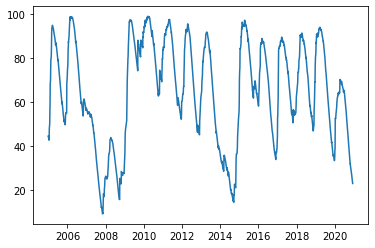

In [8]:
plt.plot(df.DATE, df.GENERAL_DAM_OCCUPANCY_RATE)

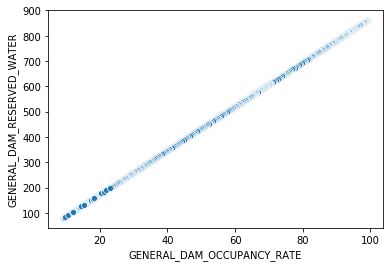

In [9]:
sns.scatterplot(data=df, x="GENERAL_DAM_OCCUPANCY_RATE", y="GENERAL_DAM_RESERVED_WATER");

In [11]:
df.shape

(5818, 3)

In [12]:
df.sort_values("DATE", inplace=True)

## Model

In [90]:
def create_dataset(dataset, window_size=30):
    data_x, data_y = [], []
    for i in range(0,dataset.shape[0]-window_size-1, 1):
        data_x.append([data for data in dataset[i:i+window_size]])
        data_y.append(dataset[i+window_size])
        
    return np.array(data_x), np.array(data_y)

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = df["GENERAL_DAM_OCCUPANCY_RATE"].values
data = scaler.fit_transform(data.reshape(-1, 1))

In [97]:
train = data[:4017]
test = data[4017:]

In [98]:
X_train , y_train = create_dataset(train)
X_test , y_test = create_dataset(test)

In [99]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [101]:
model = Sequential()
model.add(LSTM(15, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(15, return_sequences=True))
model.add(LSTM(15))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 15)            1020      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 15)            1860      
_________________________________________________________________
lstm_11 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)

Train on 3986 samples, validate on 1770 samples
Epoch 1/50
3986/3986 [==============================] - 18s 5ms/sample - loss: 0.0137 - val_loss: 0.0019
Epoch 2/50
3986/3986 [==============================] - 15s 4ms/sample - loss: 0.0014 - val_loss: 0.0012
Epoch 3/50
3986/3986 [==============================] - 16s 4ms/sample - loss: 7.0221e-04 - val_loss: 5.8006e-04
Epoch 4/50
3986/3986 [==============================] - 17s 4ms/sample - loss: 5.2418e-04 - val_loss: 4.0295e-04
Epoch 5/50
3986/3986 [==============================] - 17s 4ms/sample - loss: 4.6227e-04 - val_loss: 7.6747e-04
Epoch 6/50
3986/3986 [==============================] - 18s 5ms/sample - loss: 4.4762e-04 - val_loss: 5.4718e-04
Epoch 7/50
3986/3986 [==============================] - 17s 4ms/sample - loss: 3.9837e-04 - val_loss: 6.8499e-04
Epoch 8/50
3986/3986 [==============================] - 17s 4ms/sample - loss: 3.7580e-04 - val_loss: 5.0614e-04
Epoch 9/50
3986/3986 [==============================] - 17s 4ms/

In [104]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

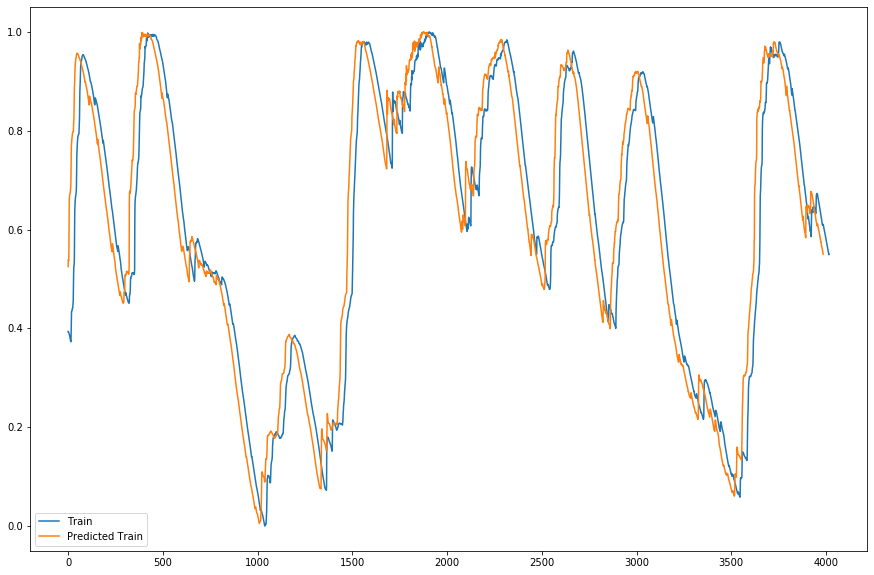

In [105]:
plt.figure(figsize=(15, 10))
plt.plot(train)
plt.plot(train_preds)
plt.legend(["Train", "Predicted Train"])

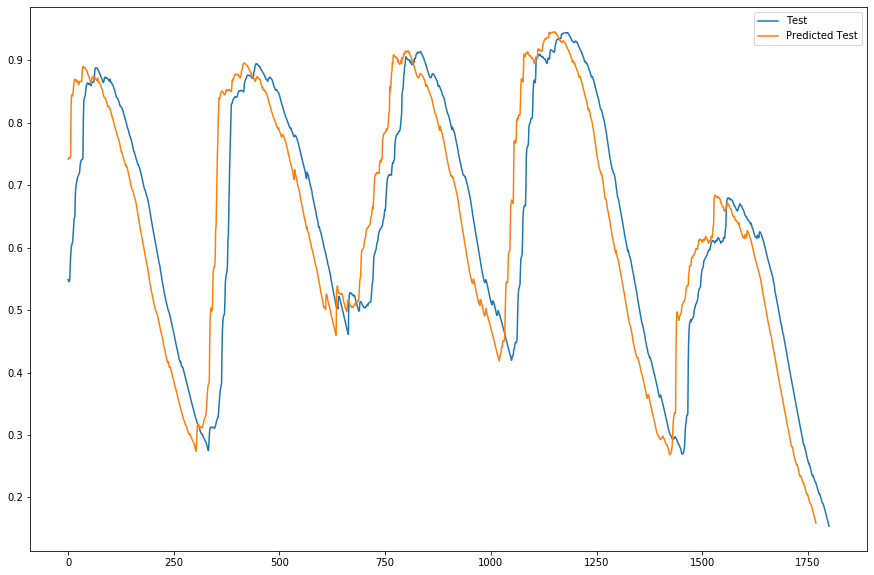

In [106]:
plt.figure(figsize=(15, 10))
plt.plot(test)
plt.plot(test_preds)
plt.legend(["Test", "Predicted Test"])